In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

In this notebook, we begin by implementing some stochastic models using Gillespie's algorithms. The models are largely based on those given in the B5.1 Stochastic Modelling of Biological Processes (https://courses.maths.ox.ac.uk/node/42068) and Keeling's Modelling Infectious Diseases in Humans and Animals.

### Stochastic Degradation

1. Set $t = 0$ and $A(t) = N$.
2. Generate a random number r $\sim \mathcal{U}(0,1)$ and set $\tau = \frac{1}{kA(t)}\ln(\frac{1}{r})$.
3. If $t + \tau \leq t_{final}$, set $t = t+\tau$ and $A(t+\tau) = A(t) - 1$. If $A(t) > 0$ return to Step 2, otherwise exit.
4. If $t > t_{final}$, set $t = t_{final}$ and exit.

In [3]:
def stochastic_degradation(A, t_final, k):
    t = 0
    A_hist = []
    t_hist = []
    while t <= t_final:
        r = np.random.rand()
        tau = math.log(1/r) / (k*A)
        t += tau
        A -= 1
        A_hist.append(A)
        t_hist.append(t)
        if A <= 0:
            break
    return t_hist, A_hist

# N = 20

t_hist_100, A_hist_100 = stochastic_degradation(20,30,0.1)

# N = 200

t_hist_1000, A_hist_1000 = stochastic_degradation(200,30,0.1)

# N = 2000

t_hist_10000, A_hist_10000 = stochastic_degradation(2000,30,0.1)


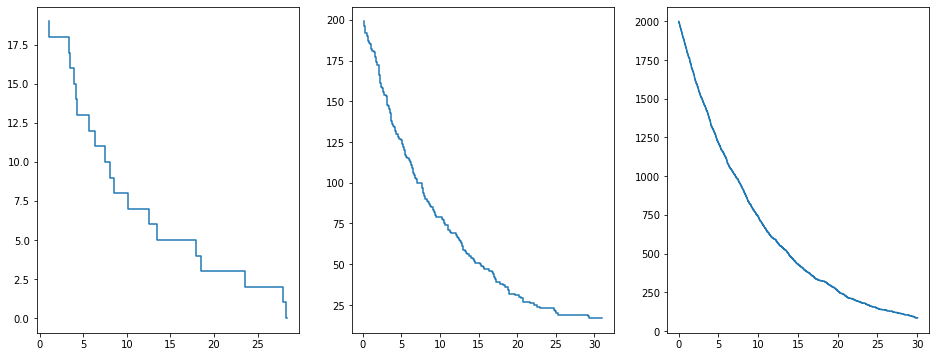

In [4]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16,6))
ax1.plot(t_hist_100, A_hist_100, drawstyle = "steps-pre")
ax2.plot(t_hist_1000, A_hist_1000, drawstyle = "steps-pre")
ax3.plot(t_hist_10000, A_hist_10000, drawstyle = "steps-pre")
plt.show()

In [5]:
# Computing the average among mutliple simulations

t_mult_histories = {}
A_mult_histories = {}
for i in range(20):
    t_hist, A_hist = stochastic_degradation(20, 30, 0.1)
    t_mult_histories[i] = t_hist
    A_mult_histories[i] = A_hist

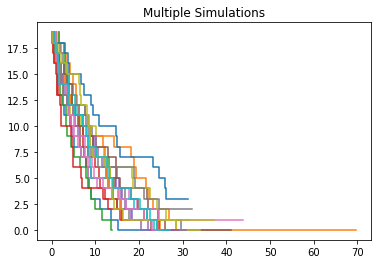

In [6]:
f, ax = plt.subplots()

for i in range(20):
    plt.plot(t_mult_histories[i], A_mult_histories[i], drawstyle = "steps-pre")
    plt.title("Multiple Simulations")

### Chemical Master Equations

If we consider a biochemical network of $N$ species, $S_1,\; S_2\;, ...,\; S_N$, that may be involved in $M$ possible reactions, $R_1, \; R_2,\; ..., R_M$. We denote the population of species $S_i$ at time $t > 0$ by its copy number $X_i(t)$ and define the state vector as
 \begin{align}
    X_t &= \begin{bmatrix}
           X_{1}(t) \\
           x_{2}(t) \\
           \vdots \\
           X_{m}(t)
         \end{bmatrix} .
  \end{align}
  
We also define the following state-change vector 
 \begin{align}
    \nu_j &= \begin{bmatrix}
           \nu_{1,j} \\
           \nu_{2,j} \\
           \vdots \\
           \nu_{N,j}
         \end{bmatrix}
  \end{align}
where $\nu_{i,j}$ is the change in species $i$ after the firing of reaction $j$. In this example, the following network containing two species $A$ and $B$:
\begin{align}
    A + A & \rightarrow \emptyset \quad \text{with rate } k_1 \\
    A + B & \rightarrow \emptyset \quad \text{with rate } k_2 \\
    \emptyset &\rightarrow A \quad \text{with rate } k_3 \\
    \emptyset &\rightarrow B \quad \text{with rate } k_4 . \\ 
\end{align}
For the above four reactions, we therefore have the following propensity functions
\begin{align}
    &a_1(t) = \frac{k_1}{\nu}A(t)(A(t) - 1) \\
    &a_2(t) = \frac{k_2}{\nu}A(t)B(t) \\
    &a_3(t) = k_3\nu \\
    &a_4(t) = k_4\nu \\
\end{align}
and the following state-change vectors
 \begin{align}
    \nu_1 &= \begin{bmatrix}
           -2 \\
           0 \\
         \end{bmatrix} ,  \quad
          \nu_2 = \begin{bmatrix}
            -1 \\
            -1 \\
         \end{bmatrix}, \quad 
           \nu_3 = \begin{bmatrix}
            +1 \\
            0 \\
         \end{bmatrix}, \quad
           \nu_4 = \begin{bmatrix}
            0 \\
            +1 \\
         \end{bmatrix} .
  \end{align}

In [7]:
def gillespie_algo(t_final, A_0, B_0, k_rates):
    
    import numpy as np
    
    def calc_a0(A, B, k_rates, return_all = True):
        a1 = calc_a1(A, B, k_rates[0])
        a2 = calc_a2(A, B, k_rates[1])
        a3 = calc_a3(A, B, k_rates[2])
        a4 = calc_a4(A, B, k_rates[3])
        if return_all:
            return a1+a2+a3+a4, [a1, a2, a3, a4]
        else:
            return a1+a2+a3+a4
    
    def calc_a1(A, B, k):
        return k*A*(A-1)
    
    def calc_a2(A, B, k):
        return k*A*B
    
    def calc_a3(A, B, k):
        return k
    
    def calc_a4(A, B, k):
        return k
    
    def v1():
        return np.array((-2, 0))
    
    def v2():
        return np.array((-1, -1))
    
    def v3():
        return np.array((+1, 0))
    
    def v4():
        return np.array((0, +1))
    
    A = A_0
    B = B_0
    [k1, k2, k3, k4] = k_rates
    t = 0
    state_hist = []
    t_hist = []
    
    prop_fns = {0:v1, 1:v2, 2:v3, 3:v4}
    
    X = np.array((A, B))
    
    while t <= t_final:
        # calculate a_0
        a_0, a_list = calc_a0(X[0], X[1], k_rates)
        # generate a reaction time
        r1 = np.random.rand()
        tau = math.log(1`/r1) / (a_0)
        t += tau
        # choose a reaction
        r2 = np.random.rand()
        for idx in range(len(a_list)):
            #print("a_i: " + str(np.sum(a_list[:idx + 1])))
            if r2*a_0 < np.sum(a_list[:idx +1]):
                reaction_idx = idx
                break
            elif idx == (len(a_list) - 1):
                reaction_idx = idx
        # update state vector
        X = X + prop_fns[reaction_idx]()
        state_hist.append(X)
        t_hist.append(t)
    return t_hist, state_hist

In [12]:
t_hist, state_hist = gillespie_algo(100, 0, 0, [0.001, 0.01, 1.2, 1.0])

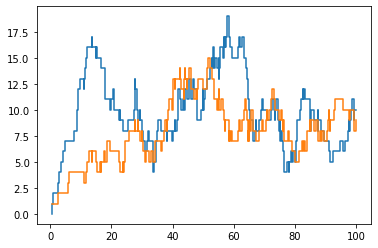

In [13]:
plt.plot(t_hist, state_hist, drawstyle = "steps-pre")
plt.show()

In [14]:
# multiple simulations

t_mult_histories = {}
A_mult_histories = {}
B_mult_histories = {}

for i in range(5):
    time_hist, state_hist = gillespie_algo(100, 0, 0, [0.001, 0.01, 1.2, 1.0])
    t_mult_histories[i] = time_hist
    A_mult_histories[i] = [item[0] for item in state_hist]
    B_mult_histories[i] = [item[1] for item in state_hist]

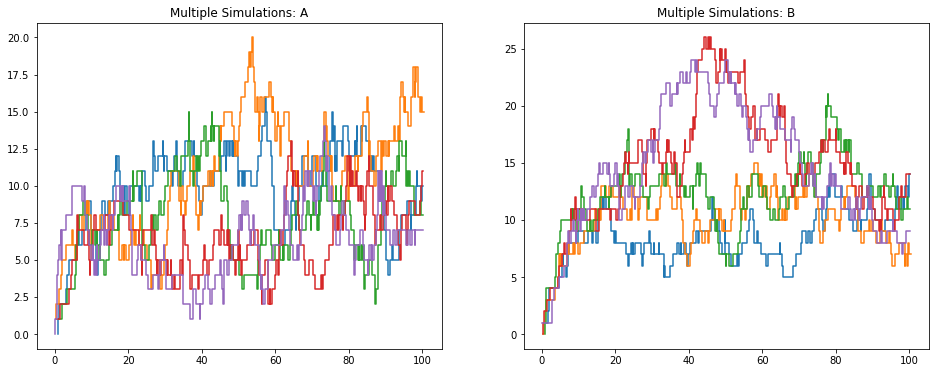

In [15]:
f, (ax1, ax2) = plt.subplots(1,2, figsize = (16,6))

for i in range(5):
    ax1.plot(t_mult_histories[i], A_mult_histories[i], drawstyle = "steps-pre")
    ax1.set_title("Multiple Simulations: A")
    
for i in range(5):
    ax2.plot(t_mult_histories[i], B_mult_histories[i], drawstyle = "steps-pre")
    ax2.set_title("Multiple Simulations: B")